# Feature Selection for Machine Learning

In the following document, I will delve into an exhaustive analysis of various feature selection techniques employed in the realm of machine learning. Gaining a profound comprehension of these methodologies holds a paramount significance, as it bears the potential to substantially diminish training durations and enhance the interpretability of machine learning models. Moreover, the judicious selection of pertinent features assumes a critical role in the transition of a model from development to production.

Feature selection, a pivotal aspect of the machine learning pipeline, empowers practitioners to discern and retain the most pertinent attributes from a pool of available features. This discerning process isn't merely about reducing computational burden but also about enhancing model performance, generalization, and ultimately, facilitating its deployment in real-world scenarios.

The focus of the notebook is to explore diverse techniques, ranging from univariate statistical tests to advanced wrapper methods and embedded approaches, we aim to uncover the nuanced interplay between feature relevance and model efficacy. This exploration is characterized by an analytical scrutiny of feature importance, correlation, redundancy, and their collective influence on the model's behavior.

The significance of this undertaking extends beyond theoretical insights; it resonates practically when one considers the resource constraints often associated with real-world applications. Efficiently selecting features not only expedites training but also bolsters a model's ability to extrapolate patterns from new data instances.

Furthermore, as machine learning models permeate various sectors, from finance to healthcare, the interpretability of these models is crucial. Understanding the rationale behind a model's decisions, which can be achieved through a well-considered feature selection process, not only builds trust but also aids in complying with regulatory standards.

## Notebook aim 

The primary objective of this notebook is to refrain from establishing a hierarchical ranking of feature selection techniques based on their effectiveness. This is because the efficacy of these techniques is contingent upon a myriad of factors, including the nature of the data, the specific business context, and the intended outcomes of the model. Instead, the notebook centers its focus on impartially visualizing and analyzing the diverse array of techniques, employing the data at hand without making any preemptive assumptions.

It's important to clarify that this notebook doesn't attempt to replicate a comprehensive data science pipeline. As a result, readers should not expect a step-by-step guide aimed at achieving the highest possible score in a competitive scenario. However, what this notebook does offer is invaluable guidance for individuals striving to attain such a favorable outcome.

For the sake of clarity, it's worth noting that this notebook deliberately avoids delving into the specifics of any particular data competition. Therefore, readers should not anticipate encountering discussions related to feature engineering or model comparisons. Instead, the focus remains squarely on the exploration of each individual feature selection technique. Each technique is executed with its default parameters, and the analysis remains independent of the nuances inherent to each specific technique.

By maintaining this approach, the notebook aspires to provide an unbiased and comprehensive overview of various feature selection strategies. This approach also safeguards against potential biases that could arise from tailored configurations geared toward achieving specific competition results. Thus, the notebook ultimately serves as a valuable resource for individuals seeking to gain a holistic understanding of these techniques, while avoiding the potential pitfalls of over-optimization.


## The data

The Titanic dataset is a well-known and often-used dataset in the field of machine learning and data science. It is named after the infamous sinking of the RMS Titanic, a British passenger liner, during its maiden voyage in 1912. The dataset contains information about the passengers on board, including whether they survived the disaster or not. This dataset is commonly used for practicing and demonstrating various data analysis, feature engineering, and machine learning techniques.

The Titanic dataset is often used as a beginner-friendly introduction to data analysis and machine learning due to its relatively small size and historical significance. It provides opportunities to explore various aspects of data preprocessing, feature engineering, missing data imputation, visualization, and predictive modeling. The goal of machine learning tasks using this dataset is typically to predict whether a given passenger would have survived the disaster based on the available features.

Many machine learning competitions and tutorials use the Titanic dataset as a starting point for learning different techniques and algorithms. It serves as a valuable resource for newcomers to the field to gain hands-on experience and insights into the process of data analysis and predictive modeling.

### Kaggle files

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Dependencies

Before executing the code in this notebook, it's crucial to install certain libraries that are not included by default in the Kaggle docker container. Make sure to install these libraries to ensure the smooth running of the code.

In [2]:
!pip install mlxtend

In [3]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 11.9 MB/s eta 0:00:00


In [4]:
!pip install feature_engine

### Principal Libraries

In [5]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
set_config(transform_output = "pandas")
%matplotlib inline

# Random State
RANDOM_STATE = 16021822 # 16/02/1822, Sir Francis Galton!

### Looking at the data

In [6]:
data = pd.read_csv("/kaggle/input/titanic/train.csv")

# Dropping Cabin
data = data.drop("Cabin", axis = 1)

# Imputing Missing values
data["Age"] = data["Age"].fillna(data.Age.median())
data["Embarked"] = data["Embarked"].fillna(data.Embarked.mode().iloc[0])

In [7]:
# X, y
X = data.drop("Survived", axis = 1)
y = data["Survived"]

### Functions

I will create a couple of functions to split, scaled, train certain model and then capture the metrics. Since I am gonna be testing many techniques this is gonna be crucial for efficiency and reduce code.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# Holding arrays
Technique = list()
Type = list()
auc_score = list()
accuracy = list()
precision = list()
recall = list()
f1_Score = list()
training_duration = list()
algorithm_duration = list()
n_dropped = list()
features_kept = list()
features_dropped = list()

def split_data(X, y):
    return train_test_split(X, y, test_size = 0.1, random_state = RANDOM_STATE)

def encode_data(X):
    for feature in ["Sex", "Embarked", "Name", "Ticket"]:
        if feature in X.columns:
            X[feature] = X[feature].map({k: i for i, k in enumerate(X[feature].unique(), 0)})
    return X
    
def scale_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def train_model(X, y):
    model = RandomForestClassifier(random_state = RANDOM_STATE)
    model.fit(X, y)
    return model

def capture_metrics(model, X_test, y_test):
    prediction = model.predict(X_test)
    proba_prediction = model.predict_proba(X_test)
    
    return [roc_auc_score(y_test, proba_prediction[:,1]),
            accuracy_score(y_test, prediction),
           precision_score(y_test, prediction, average = 'binary'),
           recall_score(y_test, prediction, average = 'binary'),
           f1_score(y_test, prediction, average = 'binary')]

def get_results(X, y, TECHNIQUE_NAME: str, TECHNIQUE_TYPE: str, scaled = False):
    
    start = time.time()

    print("Encoding, Scaling and splitting...")
    X = encode_data(X)
    if not scale_data:
        X = scale_data(X)
    X, X_test, y_train, y_test = split_data(X, y)
    
    print("Training...")
    model = train_model(X, y_train)
    
    print("Metrics...")
    metrics = capture_metrics(model, X_test, y_test)
    
    Technique.append(TECHNIQUE_NAME)
    Type.append(TECHNIQUE_TYPE)
    auc_score.append(metrics[0])
    accuracy.append(metrics[1])
    precision.append(metrics[2])
    recall.append(metrics[3])
    f1_Score.append(metrics[4])
    
    print("Complete!")
    
    end = time.time()
    time_taken = end - start
    print(f"Duration: {time_taken}")
    training_duration.append(time_taken)
    
def differences(X, NAME: str):
    temp = pd.DataFrame(columns = [f"X{number}" for number in range(len(data.drop("Survived", axis = 1).columns))],
            index = ["Original", f"{NAME}"])
    
    temp.loc["Original"] = data.drop("Survived", axis = 1).columns
    temp.loc[f"{NAME}"] = [feature if feature in X.columns else "DROPPED" for feature in data.drop("Survived", axis = 1).columns]
    
    temp["Total X"] = [data.drop("Survived", axis = 1).shape[1], X.shape[1]]
    
    n_dropped.append(temp["Total X"].iloc[0] - temp["Total X"].iloc[1])
    features_kept.append(X.columns.to_list())
    features_dropped.append([feature for feature in data.drop("Survived", axis = 1).columns if feature not in X.columns])
    
    return temp.style.applymap(lambda value: 'background-color : red' if value == "DROPPED" else '')

def create_summary():
    return pd.DataFrame({"Technique" : Technique, "Type": Type, "Total dropped": n_dropped, "Features dropped" : features_dropped,
                         "Features kept":features_kept, "AUC SCORE" : auc_score, "Accuracy" : accuracy, "Precision" : precision,
                         "Recall" : recall, "F1 Score" : f1_Score, "Time to transform": algorithm_duration,
                         "Training time":training_duration})

## Normal Data

In [9]:
differences(X, "RAW Data")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
RAW Data,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10


In [10]:
get_results(X, y, TECHNIQUE_NAME = "Original data", TECHNIQUE_TYPE = "Normal data")

algorithm_duration.append(0.0)

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.255615234375


It's important to observe that despite being aware of the relatively minimal impact of the **"PassengerId"** and **"Name"** features on model performance, I intentionally retained these features within the dataset. The rationale behind this deliberate inclusion lies in the curiosity to witness how various feature selection techniques will recognize and subsequently eliminate these less influential attributes.

---
# Filter Methods

Filter methods are a category of feature selection techniques that involve evaluating the intrinsic characteristics of features with respect to the target variable. These methods do not involve training a machine learning model; instead, they focus on assessing statistical properties or relationships between features and the target variable. The goal of filter methods is to rank or select features based on their individual attributes, which can include measures of correlation, statistical significance, and information gain.

Filter methods have some common characteristics:

1. **Independence:** Filter methods assess the relevance of features independently of each other. They don't consider the interaction between features.

2. **Speed:** These methods are generally computationally efficient, as they don't involve iterative model training.

3. **Preprocessing:** Filter methods are typically applied as a preprocessing step before training a machine learning model.

4. **Statistical Criteria:** They often use statistical metrics to quantify the relationship between each feature and the target variable.

5. **Ranking:** Features are ranked based on their scores or metrics, and a predetermined number of top-ranking features are selected for further analysis.

Filter methods can be useful for quickly identifying potentially relevant features before delving into more complex and computationally expensive feature selection techniques or model training. They can help in reducing the dimensionality of the dataset and improving model performance by focusing only on the most informative features.

Since filter methods use data statistics to take decisions we might not see that many changes in the data. However, it's important to note that filter methods have limitations as well. They might miss out on interactions between features that collectively contribute to predictive power, and their rankings can be biased by the presence of irrelevant or noisy features. Therefore, filter methods are often used in combination with other feature selection techniques to achieve better results.

---
## Filter: Constant

The "constant" filter method, also known as constant feature removal, is a simple and intuitive technique used in feature selection. In this method, features (columns) that have the same value for all instances in a dataset are identified and removed. These constant features, as the name suggests, do not provide any variability or useful information, making them irrelevant for predictive modeling tasks.

Constant features can arise due to various reasons, such as data collection errors, missing values that were filled with the same value, or simply features that are inherently constant across the entire dataset.

It's important to note that while removing constant features is a straightforward approach, it should be used as a preliminary step in the feature selection process. It might not be sufficient for more complex datasets, and combining this method with other techniques can yield better results.

In [11]:
from feature_engine.selection import DropConstantFeatures

algorithm_start = time.time()

selector =  DropConstantFeatures()

Selected_X = selector.fit_transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [12]:
differences(Selected_X, "Constant")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Constant,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10


In [13]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Constant", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.25489377975463867


---
## Filter: Quasi-Constant

The "quasi-constant" filter method, also known as quasi-constant feature removal, is an extension of the constant feature removal technique in feature selection. In this method, features that have a very low variance, indicating very little variability in their values across the dataset, are identified and considered for removal.

While constant features have the same value for all instances in the dataset, quasi-constant features might have a few different values but are heavily skewed toward a single value. These features are also considered to be uninformative because they do not contribute much to the variability of the target variable.

The process of removing quasi-constant features is similar to that of constant features, but the criterion for identifying them involves variance or some other measure of dispersion. If a feature's variance falls below a certain threshold, it is considered quasi-constant and can be removed from the dataset.

Removing quasi-constant features offers similar benefits to removing constant features, including computational efficiency, model simplification, and the avoidance of overfitting. However, this method is more nuanced as it considers a range of values, allowing for features that are only slightly variable to also be addressed.

As with any feature selection technique, the decision to use the quasi-constant filter method should be made with careful consideration of the dataset and the specific problem at hand. Combining this method with other feature selection approaches can lead to a more comprehensive and effective feature selection strategy.

In [14]:
algorithm_start = time.time()

QuasiConstantFeatures = []

for feature in X.columns:
    
    predominant = X[feature].value_counts(normalize = True).sort_values(ascending = False).values[0]
    
    if predominant > 0.998:
        
        QuasiConstantFeatures.append(feature)

Selected_X = X.drop(labels = QuasiConstantFeatures, axis = 1)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [15]:
differences(Selected_X, "Quasi-Constant")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Quasi-Constant,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10


In [16]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Quasi-Constant", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.24569392204284668


---
## Filter: Duplicated

The "duplicated" filter method, as the name suggests, is a feature selection technique that focuses on identifying and removing duplicated or highly correlated features from a dataset. Duplicated features are those that have the exact same values for all instances, while highly correlated features exhibit a strong linear relationship, potentially redundant in terms of the information they provide.

The process of using the duplicated filter method involves calculating a measure of similarity (such as Pearson's correlation coefficient) between pairs of features. If the similarity measure surpasses a certain threshold, the features are considered to be duplicated or highly correlated. At this point, one of the features is retained, while the others are removed.

It's important to exercise caution while applying the duplicated filter method, as not all correlated features need to be removed. Sometimes, correlated features might carry complementary information that can be beneficial for the model's performance. Careful consideration of the context and problem domain is crucial in deciding which features to retain and which to remove.

In practice, various programming libraries and tools offer functionalities to identify and address duplicated or highly correlated features, streamlining the process of preprocessing and feature selection.

In [17]:
algorithm_start = time.time()

Duplicated_Features, Feature_holding = {}, []

for i in range(0, len(X.columns)):

    FIRST_FEATURE = X.columns[i]
    
    if FIRST_FEATURE not in Feature_holding:
    
        Duplicated_Features[FIRST_FEATURE] = []

        for SECOND_FEATURE in X.columns[i + 1:]:

            if X[FIRST_FEATURE].equals(X[SECOND_FEATURE]):

                Duplicated_Features[FIRST_FEATURE].append(SECOND_FEATURE)
                Feature_holding.append(SECOND_FEATURE)
 
Selected_X = X[Duplicated_Features.keys()]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [18]:
differences(Selected_X, "Duplicated")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Duplicated,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10


In [19]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Duplicated", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.2517077922821045


---
## Filter: Pearson

The "Pearson correlation" filter method is a feature selection technique that leverages the Pearson correlation coefficient to measure the linear relationship between pairs of continuous numerical features in a dataset. The Pearson correlation coefficient quantifies the strength and direction (positive or negative) of the linear relationship between two variables, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear correlation.

In the context of feature selection, the Pearson correlation method is used to identify pairs of features that are highly correlated with each other. When two features are strongly correlated, they might be redundant, as they provide similar information to the model. In such cases, removing one of the correlated features can help reduce multicollinearity (correlation between predictor variables) and improve model interpretability and generalization.

The process of using the Pearson correlation filter method involves the following steps:

1. **Calculate Correlations:** Compute the Pearson correlation coefficient for each pair of numerical features in the dataset.

2. **Set a Threshold:** Choose a correlation threshold value (usually between -1 and 1) that determines the level of correlation deemed significant.

3. **Identify Correlated Features:** Identify pairs of features that have correlation coefficients above the threshold. These pairs are considered candidates for removal.

4. **Remove Features:** Depending on the context and the goal of feature selection, you can decide whether to remove one or both of the features in a correlated pair.

It's important to note that the Pearson correlation method is specifically suited for identifying linear relationships between continuous numerical variables. If your dataset contains categorical variables or non-linear relationships, the Pearson correlation might not capture the complete picture. In such cases, other correlation measures or techniques might be more appropriate.

When using the Pearson correlation filter method, it's essential to consider the domain knowledge, the specific problem you're tackling, and the implications of removing correlated features. In some cases, removing correlated features can enhance model performance, while in other cases, it might inadvertently remove relevant information.

In [20]:
from feature_engine.selection import DropCorrelatedFeatures

algorithm_start = time.time()

selector = DropCorrelatedFeatures(method = 'pearson')

Selected_X = selector.fit_transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [21]:
differences(Selected_X, "Pearson")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Pearson,PassengerId,Pclass,DROPPED,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,9


In [22]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Pearson", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.24744868278503418


---
## Filter: Metric Based

The "metric-based" filter method, also known as metric-based feature selection, is a feature selection technique that involves evaluating features based on their individual relationships with a designated evaluation metric. This evaluation metric can be a scoring function that quantifies the performance of a machine learning model on a specific task, such as classification accuracy, F1-score, area under the ROC curve (AUC-ROC), or any other suitable measure.

Unlike some other filter methods that use statistical properties or correlations, metric-based feature selection directly assesses the predictive power of each feature in relation to the chosen evaluation metric. The general process of metric-based feature selection involves the following steps:

1. **Evaluation Metric Selection:** Choose an appropriate evaluation metric that aligns with the task and goal of your machine learning model (e.g., classification, regression).

2. **Feature Scoring:** Calculate a score for each individual feature based on how well it contributes to improving the chosen evaluation metric. This scoring can involve training a machine learning model using each individual feature and measuring the resulting metric.

3. **Feature Ranking or Selection:** Rank the features based on their scores, or select a predetermined number of top-scoring features for further analysis or modeling.

Metric-based feature selection is particularly advantageous when the ultimate goal is model performance optimization on a specific task. By directly incorporating the evaluation metric in the feature selection process, this technique ensures that selected features align closely with the task's objectives. It can be especially useful when dealing with high-dimensional datasets, as it aids in pinpointing the most informative features while potentially reducing overfitting by ignoring less influential ones.

However, metric-based feature selection might not be suitable for all situations. It heavily relies on the chosen evaluation metric, which means that features selected based on one metric might not perform optimally with a different metric. Additionally, it can be computationally expensive if a complex model needs to be trained for each feature.

Careful consideration of the evaluation metric, dataset characteristics, and the potential trade-offs between model interpretability and performance is crucial when employing the metric-based filter method.

In [23]:
from feature_engine.selection import SelectBySingleFeaturePerformance

algorithm_start = time.time()

selector = SelectBySingleFeaturePerformance(estimator = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1))

Selected_X = selector.fit_transform(X, y)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
differences(Selected_X, "Metric Based")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Metric Based,DROPPED,Pclass,DROPPED,Sex,DROPPED,DROPPED,DROPPED,DROPPED,Fare,DROPPED,3


In [25]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Metric Based", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.19941210746765137


---
## Filter: Mutual information

The "Mutual Information" (MI) filter method is a feature selection technique that quantifies the statistical dependence or information shared between two variables. In the context of feature selection, Mutual Information measures the amount of information one feature provides about another or, more specifically, about the target variable. It's often used to identify features that are informative for predicting the target variable in a classification or regression task.

Mutual Information is a measure derived from information theory, a field in mathematics and computer science that deals with quantifying the amount of information contained in data. It's particularly well-suited for identifying non-linear relationships and interactions between features and the target variable.

The general process of using Mutual Information for feature selection involves these steps:

1. **Calculate Mutual Information:** Calculate the Mutual Information between each feature and the target variable. This involves assessing how much knowing the value of one feature reduces uncertainty about the target variable.

2. **Rank or Select Features:** Rank the features based on their Mutual Information scores. Higher scores indicate stronger relationships with the target variable.

3. **Set a Threshold:** Optionally, you can set a threshold to select a certain number of top-scoring features or choose features above a certain Mutual Information value.

Mutual Information is beneficial when dealing with datasets where linear correlation-based methods might not capture the full extent of feature relevance. It's particularly useful when dealing with categorical or discrete features. Additionally, Mutual Information can reveal non-linear relationships and interactions that other methods might overlook.

While Mutual Information is a powerful technique, it's important to note that it has some limitations. For instance, it might not be suitable for high-dimensional datasets due to increased computational requirements. Additionally, the interpretability of Mutual Information scores might vary based on the nature of the data and the chosen problem.

In [26]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

algorithm_start = time.time()

selector = SelectKBest(mutual_info_classif, k = int(X.shape[1] / 2)).fit(X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [27]:
differences(Selected_X, "Mutual information")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Mutual information,DROPPED,Pclass,DROPPED,Sex,DROPPED,DROPPED,DROPPED,Ticket,Fare,Embarked,5


In [28]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Mutual information", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.22147202491760254


---
## Filter: Chi-square

The "Chi-Square" filter method is a feature selection technique that is specifically designed for categorical target variables in classification tasks. It assesses the relationship between each categorical feature and the categorical target variable using the chi-square statistic, which measures the independence between two categorical variables.

The primary goal of the Chi-Square filter method is to identify features that are significantly associated with the target variable's different categories. It helps determine whether there is a statistically significant difference in the distribution of feature values across the categories of the target variable.

The general process of using the Chi-Square filter method involves the following steps:

1. **Contingency Table:** Create a contingency table (also known as a cross-tabulation) that summarizes the frequency of each combination of feature values and target variable categories.

2. **Expected Frequencies:** Calculate the expected frequencies for each cell in the contingency table under the assumption of independence between the feature and the target.

3. **Chi-Square Statistic:** Calculate the chi-square statistic based on the observed and expected frequencies. This statistic quantifies the extent to which the observed frequencies deviate from the expected frequencies.

4. **Degrees of Freedom:** Determine the degrees of freedom based on the dimensions of the contingency table.

5. **Significance Test:** Perform a chi-square significance test to determine whether the chi-square statistic is statistically significant. This involves comparing the chi-square value to a critical value from the chi-square distribution.

6. **Feature Selection:** Features with a significant chi-square statistic are considered relevant and are retained, while others may be discarded.

Chi-Square filter method is particularly suitable for datasets with categorical features and categorical target variables. It's commonly used in feature selection for text mining, sentiment analysis, and other classification tasks where both features and target variable are categorical.

However, it's important to note that the Chi-Square filter method might not capture non-linear relationships or interactions between variables. Additionally, it assumes that the expected frequencies are not too small; otherwise, the chi-square test might be less reliable.

In [29]:
from scipy.stats import chi2_contingency

algorithm_start = time.time()

p_values = []

for feature in X.columns:
    c = pd.crosstab(y, X[feature])
    p_value = chi2_contingency(c)[1]
    p_values.append(p_value)
    
selected = pd.Series(p_values, index = X.columns).sort_values(ascending = True)[0:int(X.shape[1] / 2)].index

Selected_X = X[selected]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [30]:
differences(Selected_X, "Chi-square")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Chi-square,DROPPED,Pclass,DROPPED,Sex,DROPPED,SibSp,DROPPED,DROPPED,Fare,Embarked,5


In [31]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Chi-square", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.20145583152770996


---
## Filter: ANOVA

The "ANOVA" (Analysis of Variance) filter method is a feature selection technique that employs statistical hypothesis testing to assess the significance of the variation in a continuous numerical feature with respect to a categorical target variable. ANOVA is commonly used when dealing with regression or classification tasks where the target variable is categorical.

The primary objective of ANOVA in the context of feature selection is to determine whether there are statistically significant differences in the means of the continuous feature across different categories of the target variable. In other words, ANOVA helps identify features that exhibit variations in their values that are related to the categories of the target variable.

The general process of using ANOVA for feature selection involves the following steps:

1. **Group Data:** Group the data based on the categories of the categorical target variable.

2. **Calculate Variance:** Calculate the variance within each group, as well as the variance among the groups. This involves assessing how much the feature's values vary within each category group and how much they vary between different category groups.

3. **Perform Hypothesis Test:** Use the F-test (a statistical test associated with ANOVA) to determine whether the variance among the groups is significantly larger than the variance within the groups. A significant F-statistic indicates that the feature's values are different across the categories of the target variable.

4. **Rank or Select Features:** Rank the features based on their F-statistic values or select features with F-statistic values above a certain threshold.

ANOVA is effective when you suspect that there are significant variations in the feature values across different classes of the target variable. It can help identify features that contribute to the differences between categories, potentially improving the model's ability to discriminate between classes.

However, ANOVA has some limitations. It assumes that the continuous feature follows a normal distribution, and it might not perform well if this assumption is violated. Additionally, ANOVA doesn't capture non-linear relationships between features and the target variable.

In [32]:
from sklearn.feature_selection import f_classif, SelectKBest

algorithm_start = time.time()

selector = SelectKBest(f_classif, k = int(X.shape[1] / 2)).fit(X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [33]:
differences(Selected_X, "ANOVA")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
ANOVA,DROPPED,Pclass,DROPPED,Sex,DROPPED,DROPPED,Parch,DROPPED,Fare,Embarked,5


In [34]:
get_results(Selected_X, y, TECHNIQUE_NAME = "ANOVA", TECHNIQUE_TYPE = "Filter")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.19619107246398926


---
# Wrapper Methods

Wrapper methods are a class of feature selection techniques that involve using a machine learning model's performance as a criterion to evaluate and select features. Unlike filter methods, which assess features independently of the model, wrapper methods involve training and evaluating the model multiple times with different subsets of features. The goal is to identify the optimal subset of features that yields the best model performance according to a specified evaluation metric.

Wrapper methods typically have the following characteristics:

1. **Model-Dependent:** Wrapper methods rely on a specific machine learning algorithm as part of their evaluation process. The model is trained and evaluated iteratively with different subsets of features.

2. **Feature Subsets:** These methods explore various combinations of features and evaluate their impact on model performance.

3. **Computationally Expensive:** Because wrapper methods require training the model multiple times, they can be computationally intensive, especially with large datasets or complex models.

4. **Higher Performance:** Wrapper methods aim to find feature subsets that directly improve the performance of the chosen machine learning model.

5. **Model Overfitting:** If not used carefully, wrapper methods can lead to overfitting, as they optimize feature subsets based on the specific model's behavior on the training data.

Wrapper methods can provide a more accurate assessment of the feature's relevance to the specific model's performance. However, they come with a higher computational cost due to the repeated model training. These methods can be beneficial when filter methods don't fully capture the complexity of the relationship between features and the target variable.

When using wrapper methods, it's important to select an appropriate evaluation metric, be cautious about potential overfitting, and be prepared for longer computation times compared to filter methods. Additionally, as model-dependent techniques, wrapper methods might not generalize well to different models or tasks.

---
## Wrapper: Step Forward Selection

The "step forward selection" wrapper method is a feature selection technique that involves iteratively building a model by progressively adding one feature at a time to the feature subset. This method aims to identify the optimal subset of features that maximizes the performance of a chosen machine learning model.

The general process of step forward selection involves the following steps:

1. **Initialization:** Start with an empty set of selected features.

2. **Feature Evaluation:** For each feature not yet selected, train the machine learning model using the currently selected features along with the feature under consideration. Evaluate the model's performance using a predefined evaluation metric.

3. **Feature Selection:** Select the feature that, when added to the currently selected features, results in the highest improvement in model performance according to the evaluation metric.

4. **Iteration:** Repeat steps 2 and 3 until a stopping criterion is met. This criterion could be reaching a desired number of features or observing a decline in performance improvement.

5. **Final Model:** Train the machine learning model using the selected features and evaluate its performance on a separate validation or test dataset.

Step forward selection offers several advantages:

- **Customization:** This method allows for fine-grained control over the selection process, as each iteration involves evaluating the performance gain from adding a specific feature.

- **Model Performance:** By iteratively adding features that contribute the most to model performance, step forward selection often leads to improved model accuracy.

However, there are also some considerations:

- **Computational Intensity:** Step forward selection can be computationally expensive, as it involves training the model multiple times for each feature addition.

- **Overfitting:** There's a risk of overfitting if the stopping criterion is not carefully chosen, as the method might select features that perform well on the training data but not on unseen data.

- **Limited Exploration:** Step forward selection doesn't backtrack or revisit features, potentially missing out on globally optimal feature subsets.

When using step forward selection, it's important to set the evaluation metric appropriately, manage computational resources, and be mindful of the potential for overfitting.

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector

algorithm_start = time.time()

selector = SequentialFeatureSelector(RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1), 
           k_features = int(X.shape[1] / 2), 
           forward = True, 
           floating = False, 
           verbose = 0,
           scoring = 'accuracy',
           cv = 3)

selector = selector.fit(X, y)

Selected_X = X[X.columns[list(selector.k_feature_idx_)]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [36]:
differences(Selected_X, "Step Forward Selection")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Step Forward Selection,DROPPED,Pclass,DROPPED,Sex,Age,SibSp,DROPPED,DROPPED,DROPPED,Embarked,5


In [37]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Step Forward Selection", TECHNIQUE_TYPE = "Wrapper")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.19978046417236328


---
## Wrapper: Step Backward Selection

The "step backward selection" wrapper method is a feature selection technique that is the inverse of the step forward selection method. Instead of starting with an empty set of features and adding one feature at a time, step backward selection begins with all features included and iteratively removes one feature at a time to find the optimal subset of features that maximizes model performance.

The general process of step backward selection involves the following steps:

1. **Initialization:** Start with all available features included in the feature subset.

2. **Feature Evaluation:** Train the machine learning model using the current subset of features and evaluate its performance using a specified evaluation metric.

3. **Feature Removal:** Remove the feature that, when excluded from the subset, leads to the highest improvement in model performance according to the evaluation metric.

4. **Iteration:** Repeat steps 2 and 3 until a stopping criterion is met. This criterion could be reaching a desired number of features or observing a decline in performance improvement.

5. **Final Model:** Train the machine learning model using the selected features and evaluate its performance on a separate validation or test dataset.

Step backward selection shares similarities with step forward selection but takes the approach of starting with all features and iteratively removing them based on their impact on model performance.

Step backward selection offers similar advantages and considerations as step forward selection:

- **Customization:** Step backward selection allows for fine-tuning the selection process by evaluating the performance impact of removing each feature.

- **Model Performance:** By iteratively removing features that contribute the least to model performance, step backward selection often leads to improved model accuracy.

- **Computational Intensity:** Like step forward selection, step backward selection can be computationally demanding due to the repeated model training.

- **Overfitting:** There's a risk of overfitting if the stopping criterion is not well-defined, as the method might end up removing features that could generalize well to unseen data.

- **Limited Exploration:** Step backward selection doesn't backtrack or reconsider features, potentially missing out on globally optimal feature subsets.

When using step backward selection, similar precautions should be taken with regard to setting the evaluation metric, managing computational resources, and addressing the possibility of overfitting.

In [38]:
from mlxtend.feature_selection import SequentialFeatureSelector

algorithm_start = time.time()

selector = SequentialFeatureSelector(RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1), 
           k_features = int(X.shape[1] / 2), forward = False, floating = False, verbose = 0, 
           scoring = 'roc_auc', cv = 3)

selector = selector.fit(X, y)

Selected_X = X[X.columns[list(selector.k_feature_idx_)]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [39]:
differences(Selected_X, "Step Backward Selection")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Step Backward Selection,DROPPED,Pclass,DROPPED,Sex,Age,DROPPED,DROPPED,Ticket,Fare,DROPPED,5


In [40]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Step Backward Selection", TECHNIQUE_TYPE = "Wrapper")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.23719477653503418


---
## Wrapper: Exhaustive Selection

Exhaustive selection, also known as "exhaustive search," is a comprehensive wrapper method for feature selection in machine learning. This technique involves evaluating all possible subsets of features from the dataset and selecting the subset that results in the best model performance according to a specified evaluation metric. While exhaustive selection is very thorough, it can become computationally expensive and time-consuming, especially for datasets with a large number of features.

The general process of exhaustive selection involves the following steps:

1. **Subset Generation:** Generate all possible combinations of features from the dataset, including subsets of different sizes.

2. **Model Training and Evaluation:** For each generated subset, train a machine learning model using the selected features and evaluate its performance using a predefined evaluation metric.

3. **Best Subset Identification:** Identify the subset of features that yields the highest model performance according to the evaluation metric.

4. **Final Model:** Train the machine learning model using the selected best subset of features and evaluate its performance on a separate validation or test dataset.

Exhaustive selection is appealing because it guarantees finding the optimal subset of features that maximizes the chosen model's performance. However, it comes with several significant considerations:

- **Computational Intensity:** The number of possible subsets grows exponentially with the number of features. As a result, exhaustive selection can be extremely computationally expensive, especially for datasets with a large number of features.

- **Resource Demands:** This method requires a substantial amount of computational resources and time, making it less practical for real-world applications with tight deadlines.

- **Curse of Dimensionality:** As the number of features increases, the time and resources required for exhaustive selection grow exponentially, which can make it infeasible for high-dimensional datasets.

- **Overfitting:** Similar to other wrapper methods, there's a potential for overfitting if the stopping criterion is not well-defined, as the method might optimize the model specifically for the training data.

Exhaustive selection is most suitable for scenarios where computational resources are not a constraint, and achieving the absolute best model performance is the primary goal. In practice, due to its high computational demands, it might not be feasible for large datasets with many features. As an alternative, it can be beneficial to explore more efficient wrapper methods or a combination of both filter and wrapper methods to strike a balance between accuracy and computational cost.

In [41]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

algorithm_start = time.time()

selector = ExhaustiveFeatureSelector(RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1),
          scoring = 'roc_auc', cv = 3, min_features = 3, max_features = 7)

selector = selector.fit(X, y)

Selected_X = X[X.columns[list(selector.best_idx_)]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

Features: 912/912

In [42]:
differences(Selected_X, "Exhaustive Selection")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Exhaustive Selection,DROPPED,Pclass,DROPPED,Sex,Age,DROPPED,DROPPED,Ticket,Fare,Embarked,6


In [43]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Exhaustive Selection", TECHNIQUE_TYPE = "Wrapper")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.22439861297607422


---
## Wrapper: Logistic

The "logistic regression" wrapper method is a feature selection technique that involves using a logistic regression model as the evaluation criterion to select the most relevant features for a classification task. In this approach, a logistic regression model is trained iteratively with different subsets of features, and the subset that results in the best model performance is selected.

The general process of using logistic regression as a wrapper method for feature selection involves the following steps:

1. **Initialization:** Start with an empty set of selected features.

2. **Feature Evaluation:** For each feature not yet selected, train a logistic regression model using the currently selected features along with the feature under consideration. Evaluate the model's performance using a predefined evaluation metric, such as accuracy or F1-score.

3. **Feature Selection:** Select the feature that, when added to the currently selected features, leads to the highest improvement in model performance according to the evaluation metric.

4. **Iteration:** Repeat steps 2 and 3 until a stopping criterion is met. This criterion could be reaching a desired number of features or observing a decline in performance improvement.

5. **Final Model:** Train the logistic regression model using the selected features and evaluate its performance on a separate validation or test dataset.

Using logistic regression as a wrapper method for feature selection has several benefits:

- **Model Compatibility:** Logistic regression is a natural choice for classification tasks, making it a suitable model for evaluating feature relevance in a classification context.

- **Interpretability:** Logistic regression provides interpretable coefficients for each selected feature, aiding in understanding their impact on the model's predictions.

- **Regularization:** Depending on the implementation, logistic regression can automatically perform feature selection by applying regularization techniques like L1 regularization (Lasso), which encourages some feature coefficients to be exactly zero.

However, it's important to consider the following:

- **Computational Cost:** Repeatedly training logistic regression models can be computationally demanding, especially with large datasets.

- **Feature Dependencies:** Logistic regression assumes linear relationships between features and the target variable. Non-linear relationships might not be well-captured by this method.

- **Overfitting:** Care should be taken to avoid overfitting by using cross-validation, proper stopping criteria, and regularization if applicable.

Logistic regression-based wrapper methods are most beneficial when logistic regression is a suitable model for the task and when feature interpretability and model performance are key priorities. In practice, combining wrapper methods with other techniques can help strike a balance between accuracy, computational cost, and model complexity.

In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

algorithm_start = time.time()

# NOTE: Features need to be scaled
Scaled_X = scale_data(X)

selector = SelectFromModel(LogisticRegression(random_state = RANDOM_STATE))

selector.fit(Scaled_X, y)

Selected_X = X[X.columns[(selector.get_support())]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [45]:
differences(Selected_X, "Logistic")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Logistic,DROPPED,Pclass,DROPPED,Sex,Age,SibSp,DROPPED,DROPPED,DROPPED,DROPPED,4


In [46]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Logistic", TECHNIQUE_TYPE = "Wrapper", scaled = True)

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.19311809539794922


---
## Wrapper: Lasso regularization

The "Lasso" (Least Absolute Shrinkage and Selection Operator) regularization, often referred to as L1 regularization, is a feature selection technique that is applied as part of a machine learning model's training process. Lasso adds a penalty term to the linear regression or logistic regression loss function to encourage some feature coefficients to become exactly zero. As a result, Lasso not only performs regression or classification but also inherently performs feature selection by reducing the impact of less important features.

The general concept of Lasso regularization involves these key aspects:

1. **Regularization Term:** Lasso adds a penalty term to the loss function during model training. The penalty is proportional to the absolute value of the coefficients of the features.

2. **Shrinking Coefficients:** The penalty term encourages the optimization algorithm to minimize the sum of the absolute values of the coefficients. This shrinking effect results in some coefficients becoming exactly zero.

3. **Sparse Model:** The zero coefficients indicate that the corresponding features have been effectively excluded from the model, effectively performing feature selection.

Lasso regularization is particularly suitable when there are many features, some of which might be irrelevant or redundant. It automatically identifies and selects the most relevant features for the task, resulting in a more interpretable and potentially better-performing model.

Lasso regularization is advantageous for the following reasons:

- **Feature Selection:** Lasso naturally performs feature selection by driving some coefficients to zero, effectively excluding irrelevant or less important features.

- **Interpretability:** The model's sparsity due to zero coefficients leads to a more interpretable model.

- **Dimensionality Reduction:** Lasso helps reduce the dimensionality of the problem by excluding irrelevant features.

However, there are also considerations:

- **Feature Dependencies:** Lasso might arbitrarily select one feature from a group of highly correlated features while setting the others to zero.

- **Regularization Strength:** The regularization strength parameter should be appropriately chosen to control the balance between fitting the data and feature selection.

- **Model Sensitivity:** Lasso's effectiveness depends on the data and problem at hand. The choice of regularization strength and the data's characteristics can impact its performance.

In [47]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

algorithm_start = time.time()

# NOTE: Features need to be scaled
Scaled_X = scale_data(X)

selector = SelectFromModel(LogisticRegression(C = 0.5, penalty = 'l1', solver = 'liblinear', random_state = RANDOM_STATE))

selector.fit(Scaled_X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [48]:
differences(Selected_X, "Lasso Regularization")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Lasso Regularization,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,DROPPED,Fare,Embarked,9


In [49]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Lasso Regularization", TECHNIQUE_TYPE = "Wrapper", scaled = True)

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.2348628044128418


---
## Wrapper: Tree Importance 

The "Tree Importance" wrapper method, often referred to as feature importance derived from decision trees or ensemble methods like Random Forests, is a feature selection technique that evaluates the significance of features based on their contribution to the predictive accuracy of a machine learning model.

Tree Importance is typically used with decision tree-based models or ensemble techniques like Random Forests or Gradient Boosting. These models inherently assess the importance of features during the training process and provide a quantitative measure of how much each feature contributes to improving the model's performance.

The general process of using Tree Importance for feature selection involves these steps:

1. **Model Training:** Train a decision tree-based model or an ensemble model (e.g., Random Forest, Gradient Boosting) using the entire set of features and the corresponding target variable.

2. **Feature Importance Calculation:** Extract the feature importance scores from the trained model. These scores indicate how much each feature contributes to the model's accuracy.

3. **Rank or Select Features:** Rank the features based on their importance scores or select a predetermined number of top-scoring features.

4. **Final Model:** Train the machine learning model using the selected features and evaluate its performance on a separate validation or test dataset.

Tree Importance is advantageous for several reasons:

- **Inherent Feature Evaluation:** Decision tree-based models naturally assess feature importance during their training process. This eliminates the need for separate feature selection steps.

- **Non-linearity and Interactions:** Tree-based models can capture non-linear relationships and interactions between features, making them suitable for tasks where such patterns are present.

- **Model Performance:** Features contributing most to the model's predictive accuracy are retained, potentially leading to improved model performance.

However, it's essential to consider:

- **Bias Towards Strong Predictors:** Tree Importance might emphasize strong predictors, potentially overlooking relevant but weaker predictors.

- **Data Sensitivity:** The importance of features can vary based on the dataset, problem, and model chosen.

- **Model Choice:** Tree Importance is most applicable to decision tree-based models and ensembles. For linear models, other feature selection methods might be more suitable.

In [50]:
from sklearn.feature_selection import SelectFromModel

algorithm_start = time.time()

selector = SelectFromModel(RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1))

selector.fit(X, y)

Selected_X = X[X.columns[(selector.get_support())]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [51]:
differences(Selected_X, "Tree Importance")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Tree Importance,PassengerId,DROPPED,Name,Sex,Age,DROPPED,DROPPED,Ticket,Fare,DROPPED,6


In [52]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Tree Importance", TECHNIQUE_TYPE = "Wrapper")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.24142980575561523


---
## Wrapper: Recursive Selection

The "Recursive Selection" wrapper method is a feature selection technique that involves recursively training a machine learning model on different subsets of features and evaluating the model's performance to determine the optimal subset. It's a sequential process that iteratively adds or removes features based on their impact on model performance.

The Recursive Selection method can be further categorized into two main subtypes: Recursive Feature Elimination (RFE) and Recursive Feature Addition (RFA).

1. **Recursive Feature Elimination (RFE):** In RFE, the process starts with all features included and iteratively removes the least important feature(s) based on a certain criterion. The model is retrained each time, and the least important features are pruned.

2. **Recursive Feature Addition (RFA):** In RFA, the process begins with no features included and iteratively adds the most important feature(s) based on a certain criterion. The model is retrained with the added features at each step.

The general process of Recursive Selection involves these steps:

1. **Initialization:** Start with either all features included (for RFE) or no features included (for RFA).

2. **Model Training and Evaluation:** Train a machine learning model using the selected features and evaluate its performance using a predefined evaluation metric.

3. **Feature Adjustment:** Depending on the subtype (RFE or RFA), either remove the least important feature or add the most important feature.

4. **Iteration:** Repeat steps 2 and 3 for a predetermined number of iterations or until a stopping criterion is met.

5. **Final Model:** Train the machine learning model using the selected features and evaluate its performance on a separate validation or test dataset.

Recursive Selection offers several benefits:

- **Thorough Exploration:** Recursive Selection method explores different subsets of features, systematically assessing their impact on model performance.

- **Customization:** The process can be customized by selecting the number of features to include or exclude in each iteration.

- **Feature Ranking:** The selection process inherently ranks features based on their importance, aiding in understanding feature relevance.

However, there are also considerations:

- **Computational Demand:** Repeatedly training and evaluating models can be computationally intensive.

- **Overfitting:** Care should be taken to avoid overfitting, particularly if the stopping criterion is not well-defined.

- **Model Choice:** Recursive Selection is applicable to various machine learning models, but the choice of the base model affects its performance.

Recursive Selection is most suitable when a thorough exploration of feature subsets is desired, and when the computational resources are sufficient to handle the repeated model training. It can lead to improved model performance and interpretability by identifying the most relevant subset of features.

In [53]:
from sklearn.feature_selection import RFE

algorithm_start = time.time()

selector = RFE(RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1), n_features_to_select = int(X.shape[1] / 2))

selector.fit(X, y)

Selected_X = X[X.columns[(selector.get_support())]]

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [54]:
differences(Selected_X, "Recursive Selection")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Recursive Selection,DROPPED,DROPPED,Name,Sex,Age,DROPPED,DROPPED,Ticket,Fare,DROPPED,5


In [55]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Recursive Selection", TECHNIQUE_TYPE = "Wrapper")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.24108338356018066


---
# Hybrid Methods

Hybrid methods in feature selection are approaches that combine elements from different types of feature selection techniques, such as filter and wrapper methods, to take advantage of their strengths while mitigating their weaknesses. Hybrid methods aim to provide a more comprehensive and balanced approach to selecting relevant features for a machine learning model. They typically involve integrating different steps or components from multiple techniques to achieve better feature selection results.

---
## Hybrid: Feature Shuffling

Feature shuffling is not commonly referred to as a "hybrid method" in the traditional sense of combining different types of feature selection techniques. Instead, it's a technique used for assessing the importance of individual features in a machine learning model, particularly in the context of evaluating feature relevance and understanding their impact on model predictions.

Feature shuffling involves a simple yet effective process:

1. **Initial Model Training:** Train a machine learning model using the original dataset, including all features.

2. **Feature Importance Calculation:** Calculate the baseline feature importance scores using the trained model. These scores indicate the contribution of each feature to the model's performance.

3. **Shuffling:** Randomly shuffle the values of a specific feature while keeping the target variable values intact. This destroys any genuine relationship between the feature and the target.

4. **Model Evaluation:** Reevaluate the model's performance using the shuffled feature. The drop in performance indicates the significance of the shuffled feature.

5. **Repeat:** Repeat steps 3 and 4 for each feature to assess the impact of shuffling on the model's performance.

By comparing the drop in model performance when a feature is shuffled with its baseline importance score, one can infer the relative importance of that feature. Features that, when shuffled, lead to a significant drop in performance are likely to be important for the model's predictions.

While feature shuffling is a valuable technique for assessing feature importance and understanding their contributions, it's not a hybrid method in the traditional sense, as it doesn't combine elements from different feature selection techniques. It's a technique on its own that provides insights into feature relevance and can be a part of a larger toolkit for feature selection and model interpretation.

In [56]:
from feature_engine.selection import SelectByShuffling

algorithm_start = time.time()

random_forest = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -1)

selector = SelectByShuffling(estimator = random_forest, random_state = RANDOM_STATE, threshold = 0)

selector.fit(X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [57]:
differences(Selected_X, "Feature Shuffling")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Feature Shuffling,DROPPED,Pclass,DROPPED,Sex,DROPPED,DROPPED,DROPPED,DROPPED,DROPPED,DROPPED,2


In [58]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Feature Shuffling", TECHNIQUE_TYPE = "Hybrid")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.16796350479125977


---
## Hybrid: Recursive Feature Elimination

Recursive Feature Elimination (RFE) is a specific feature selection technique that often falls into the category of wrapper methods, as it involves using a machine learning model's performance as a criterion to select features. However, RFE can also be considered a hybrid method due to its iterative nature and its incorporation of filter-like characteristics.

The general process of Recursive Feature Elimination involves the following steps:

1. **Model Training and Evaluation:** Train a machine learning model using all available features and evaluate its performance using a predefined evaluation metric.

2. **Feature Ranking:** Rank the features based on their importance scores obtained from the trained model.

3. **Feature Elimination:** Remove the feature with the lowest importance score from the dataset.

4. **Model Retraining:** Train the machine learning model again, this time using the remaining features.

5. **Iteration:** Repeat steps 2-4 until a stopping criterion is met, such as reaching a desired number of features or observing a decline in model performance.

6. **Final Model:** Train the machine learning model using the selected subset of features and evaluate its performance on a separate validation or test dataset.

RFE combines elements of both filter and wrapper methods:

- **Filter-Like Aspect:** In each iteration, RFE evaluates the importance of features and eliminates the least important one, which is reminiscent of filter methods' ranking or scoring process.

- **Wrapper-Like Aspect:** RFE iteratively trains and evaluates a machine learning model using different subsets of features, similar to the wrapper methods' approach.

RFE is considered a hybrid method because it takes advantage of a machine learning model's predictive ability to assess feature importance, while also implementing an iterative process to refine the feature subset. It provides a balance between efficiency and effectiveness by iteratively eliminating less important features based on their contribution to the model's performance.

While RFE is effective, it's important to consider the computational demands, the choice of the base model, and the potential for overfitting during the selection process. It's particularly beneficial when interpretability and model performance are both important considerations.

In [59]:
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.ensemble import GradientBoostingClassifier

algorithm_start = time.time()

Gradient_Boosting = GradientBoostingClassifier(random_state = RANDOM_STATE)

selector = RecursiveFeatureElimination(estimator = Gradient_Boosting, threshold = 0.0001)

selector.fit(X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [60]:
differences(Selected_X, "Recursive Feature Elimination")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Recursive Feature Elimination,DROPPED,Pclass,DROPPED,Sex,Age,SibSp,DROPPED,Ticket,Fare,Embarked,7


In [61]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Recursive Feature Elimination", TECHNIQUE_TYPE = "Hybrid")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.2176990509033203


---
## Hybrid: Recursive Feature Addition

Recursive Feature Addition (RFA) is a feature selection technique that also falls under the wrapper methods category while having characteristics of hybrid methods due to its iterative approach. Similar to Recursive Feature Elimination (RFE), RFA involves training and evaluating a machine learning model on different subsets of features. However, RFA follows a different strategy by iteratively adding features based on their importance to the model's performance.

The general process of Recursive Feature Addition involves the following steps:

1. **Model Training and Evaluation:** Train a machine learning model using no features and evaluate its performance using a predefined evaluation metric.

2. **Feature Ranking:** Rank the remaining features based on their importance scores obtained from the trained model.

3. **Feature Addition:** Add the feature with the highest importance score to the feature set.

4. **Model Retraining:** Train the machine learning model again, this time using the new set of features.

5. **Iteration:** Repeat steps 2-4 until a stopping criterion is met, such as reaching a desired number of features or observing a decline in model performance.

6. **Final Model:** Train the machine learning model using the selected subset of features and evaluate its performance on a separate validation or test dataset.

RFA shares similarities with both filter and wrapper methods:

- **Filter-Like Aspect:** RFA ranks features based on their importance scores before adding them to the model, similar to the ranking process in filter methods.

- **Wrapper-Like Aspect:** RFA iteratively trains and evaluates a machine learning model using different subsets of features, akin to the wrapper methods' iterative approach.

RFA, like RFE, can be considered a hybrid method because it combines the benefits of a machine learning model's performance assessment with an iterative process for feature subset refinement. It seeks to find the most informative features for the model by iteratively adding them to the feature set.

When using RFA, it's essential to consider the computational demands, the choice of the base model, and the potential for overfitting during the iterative process. RFA is particularly useful when interpretability and model performance are both critical aspects of the feature selection process.

In [62]:
from feature_engine.selection import RecursiveFeatureAddition

algorithm_start = time.time()

Gradient_Boosting = GradientBoostingClassifier(random_state = RANDOM_STATE)

selector = RecursiveFeatureAddition(estimator = Gradient_Boosting, threshold = 0.0001)

selector.fit(X, y)

Selected_X = selector.transform(X)

algorithm_end = time.time()

algorithm_duration.append(algorithm_end - algorithm_start)

In [63]:
differences(Selected_X, "Recursive Feature Addition")

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Total X
Original,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,10
Recursive Feature Addition,DROPPED,Pclass,DROPPED,Sex,Age,SibSp,DROPPED,DROPPED,Fare,Embarked,6


In [64]:
get_results(Selected_X, y, TECHNIQUE_NAME = "Recursive Feature Addition", TECHNIQUE_TYPE = "Hybrid")

Encoding, Scaling and splitting...
Training...
Metrics...
Complete!
Duration: 0.21464157104492188


# Other methods to explore
## Wrapper: Linear Regression


The "linear regression" wrapper method is a feature selection technique that involves using a linear regression model as the evaluation criterion to select relevant features for a regression task. This approach employs a linear regression model to evaluate different subsets of features and identifies the subset that leads to the best model performance.

The general process of using linear regression as a wrapper method for feature selection involves these steps:

1. **Initialization:** Begin with an empty set of selected features.

2. **Feature Evaluation:** For each feature not yet selected, train a linear regression model using the currently selected features along with the feature under consideration. Evaluate the model's performance using a predefined evaluation metric, such as mean squared error (MSE) or R-squared.

3. **Feature Selection:** Select the feature that, when added to the currently selected features, results in the highest improvement in model performance according to the evaluation metric.

4. **Iteration:** Repeat steps 2 and 3 until a stopping criterion is met. This criterion could be reaching a desired number of features or observing a decline in performance improvement.

5. **Final Model:** Train the linear regression model using the selected features and evaluate its performance on a separate validation or test dataset.

Using linear regression as a wrapper method for feature selection offers certain advantages:

- **Model Compatibility:** Linear regression is a natural choice for regression tasks, making it well-suited for evaluating feature relevance in a regression context.

- **Interpretability:** Linear regression coefficients indicate the direction and strength of the relationship between each selected feature and the target variable, aiding in understanding their impact on predictions.

- **Simplicity:** The linear regression model's simplicity allows for relatively quick iterations during the selection process.

However, there are important considerations:

- **Computational Demand:** Repeatedly training linear regression models can be computationally demanding, particularly with large datasets.

- **Linear Assumption:** Linear regression assumes a linear relationship between features and the target variable. Non-linear relationships may not be accurately captured by this method.

- **Overfitting:** Overfitting can occur if not managed properly. Cross-validation, regularization, and appropriate stopping criteria are essential.

Linear regression-based wrapper methods are most effective when linear regression is a suitable model for the task, and when interpretability and model performance are key priorities. Combining wrapper methods with other techniques can provide a more comprehensive approach to feature selection, considering aspects such as non-linear relationships and computational efficiency.

# Results

In [65]:
SUMMARY = create_summary()

In [66]:
SUMMARY

,Technique,Type,Total dropped,Features dropped,Features kept,AUC SCORE,Accuracy,Precision,Recall,F1 Score,Time to transform,Training time
0,Original data,Normal data,0,[],"[PassengerId, Pclass, Name, Sex, Age, SibSp, P...",0.894841,0.800000,0.875000,0.666667,0.756757,0.000000,0.255615
1,Constant,Filter,0,[],"[PassengerId, Pclass, Name, Sex, Age, SibSp, P...",0.894841,0.800000,0.875000,0.666667,0.756757,0.005947,0.254894
2,Quasi-Constant,Filter,0,[],"[PassengerId, Pclass, Name, Sex, Age, SibSp, P...",0.894841,0.800000,0.875000,0.666667,0.756757,0.007298,0.245694
3,Duplicated,Filter,0,[],"[PassengerId, Pclass, Name, Sex, Age, SibSp, P...",0.894841,0.800000,0.875000,0.666667,0.756757,0.004656,0.251708
4,Pearson,Filter,1,[Name],"[PassengerId, Pclass, Sex, Age, SibSp, Parch, ...",0.910466,0.822222,0.882353,0.714286,0.789474,0.006571,0.247449
5,Metric Based,Filter,7,"[PassengerId, Name, Age, SibSp, Parch, Ticket,...","[Pclass, Sex, Fare]",0.913690,0.866667,0.857143,0.857143,0.857143,5.237353,0.199412
6,Mutual information,Filter,5,"[PassengerId, Name, Age, SibSp, Parch]","[Pclass, Sex, Ticket, Fare, Embarked]",0.911210,0.855556,0.871795,0.809524,0.839506,0.042875,0.221472
7,Chi-square,Filter,5,"[PassengerId, Name, Age, Parch, Ticket]","[Sex, Pclass, Fare, SibSp, Embarked]",0.886409,0.822222,0.861111,0.738095,0.794872,0.437601,0.201456
8,ANOVA,Filter,5,"[PassengerId, Name, Age, SibSp, Ticket]","[Pclass, Sex, Parch, Fare, Embarked]",0.909226,0.833333,0.846154,0.785714,0.814815,0.005989,0.196191
9,Step Forward Selection,Wrapper,5,"[PassengerId, Name, Parch, Ticket, Fare]","[Pclass, Sex, Age, SibSp, Embarked]",0.896825,0.844444,0.868421,0.785714,0.825000,16.904784,0.199780


## Computational demand

To evaluate the computational demands, I conducted measurements on two distinct parameters:

**Training Time:** Training time refers to the amount of time it takes to train a machine learning model on a given dataset. During the training process, the model learns from the data to make predictions or classifications. The training time can vary significantly based on factors such as the complexity of the model, the size of the dataset, the hardware used (like GPUs or TPUs), and the optimization techniques employed.

Longer training times might be required for more complex models (e.g., deep neural networks) or larger datasets. Techniques like mini-batch training, distributed training, and model parallelism can be used to speed up training time. The goal is to find a balance between training time and model performance, as longer training times might lead to better results but could also increase resource requirements.

**Algorithm Runtime:** Algorithm runtime refers to the time it takes for the transformation (Feature Selection) technique to finish the entire process.The runtime of an algorithm can depend on the complexity of the transformation itself and the amount of computation required for each technique. For instance, simpler algorithm like filter methods might have very short runtimes, while more complex models like Exhaustive Selection might have longer runtimes due to the number of iterations and parameters.

Both training time and algorithm runtime are important considerations in machine learning, especially when deploying models in real-world applications. Balancing the trade-off between model complexity, training time, and runtime is crucial to ensure that the model can provide accurate predictions while being efficient in terms of resource usage.

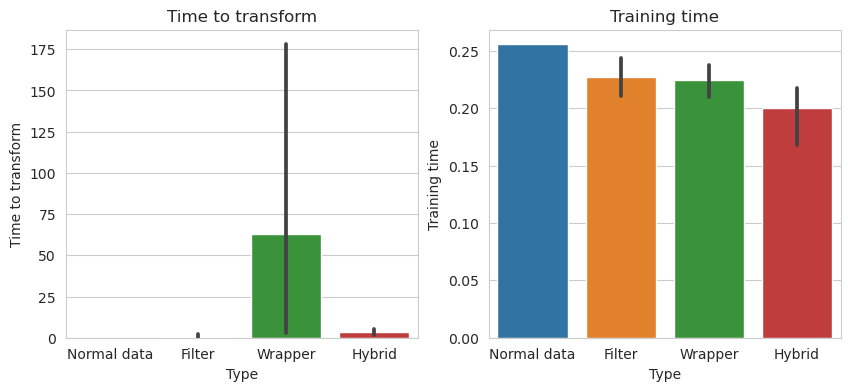

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4), sharey = False)

sns.barplot(data = SUMMARY, x = "Type", y = "Time to transform",
            estimator = "mean", ax = ax1)
ax1.set_title("Time to transform")
sns.barplot(data = SUMMARY, x = "Type", y = "Training time",
            estimator = "mean", ax = ax2)
ax2.set_title("Training time");

In [68]:
SUMMARY.groupby("Type").mean()[['Time to transform', "Training time"]].style.highlight_max(axis = 0,
                                                                                           color = "red")

,Time to transform,Training time
Type,,
Filter,0.718536,0.227284
Hybrid,3.195749,0.200101
Normal data,0.000000,0.255615
Wrapper,62.932954,0.224553


Wrapper methods for feature selection often involve lengthier data transformation compared to filter methods due to their iterative nature and reliance on model training and evaluation. This time discrepancy stems from various factors, including: the need for training and evaluating a machine learning model repeatedly for different feature subsets, which becomes computationally intensive for complex models or large datasets; the iterative process of assessing feature impacts on model performance introduces additional computation steps; some wrapper methods employ intricate models like ensembles or deep learning, necessitating more time for training and evaluation; cross-validation, commonly used to ensure robust performance assessment, increases computational workload; hyperparameter tuning in certain wrapper methods adds computational complexity; and techniques to prevent overfitting, such as cross-validation and regularization, contribute to computational demands.

In contrast, filter and hybrid methods are generally faster due to their independence from model specifics. They compute statistical metrics or scores directly from the data, without requiring multiple iterations of model training and evaluation. This characteristic makes filter and hybrid methods more efficient, especially for large datasets or limited computational resources. Despite wrapper methods' longer processing times, they offer accurate feature assessments by considering the model's behavior. The choice between filter and wrapper methods depends on factors like available resources, dataset size, desired model performance, and the trade-off between processing time and feature selection precision.

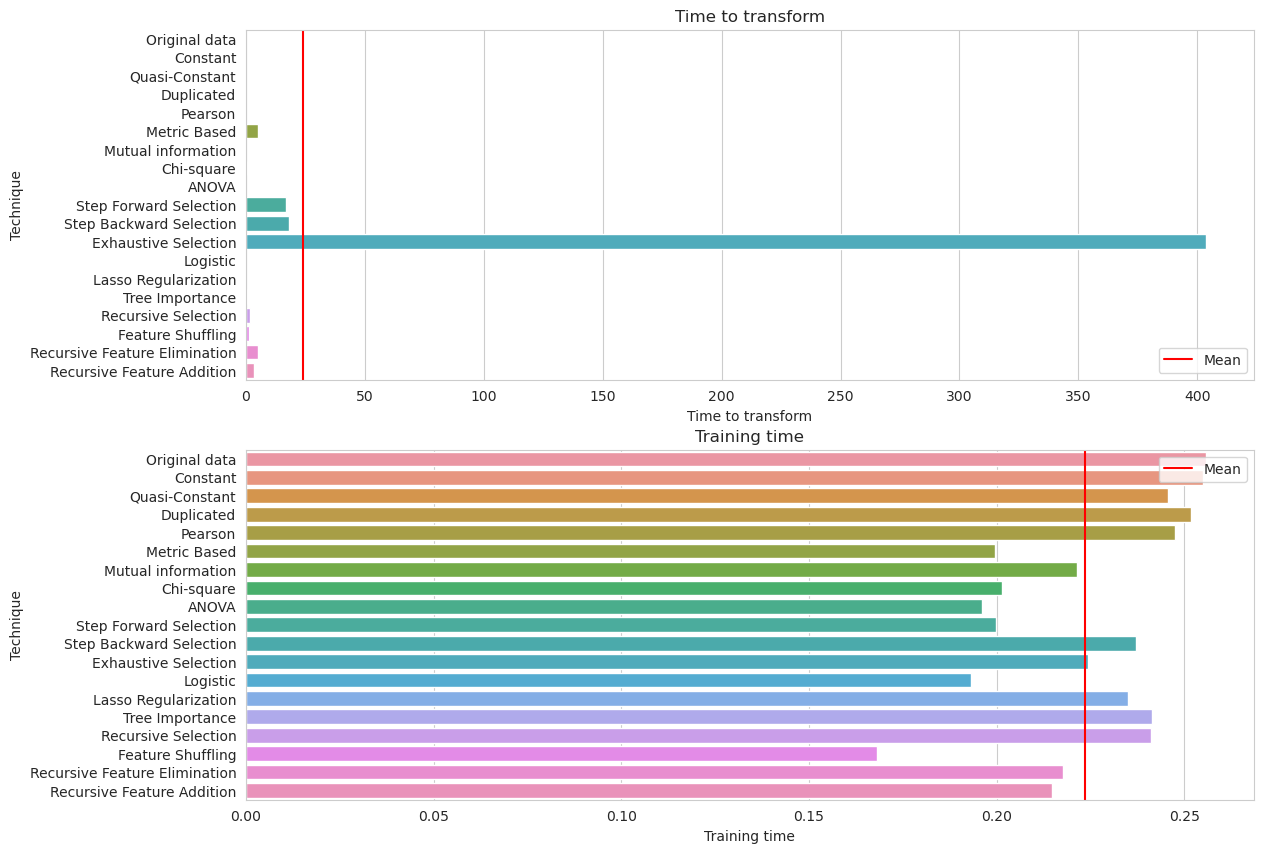

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (13, 10), sharex = False)

sns.barplot(data = SUMMARY, y = "Technique", x = "Time to transform", ax = ax1)
ax1.axvline(SUMMARY['Time to transform'].mean(), color = 'r', label = "Mean")
ax1.set_title("Time to transform")
ax1.legend(loc = "lower right")
sns.barplot(data = SUMMARY, y = "Technique", x = "Training time", ax = ax2)
ax2.axvline(SUMMARY['Training time'].mean(), color = 'r', label = "Mean")
ax2.set_title("Training time")
ax2.legend(loc = "upper right");

It is noticeable that Exhaustive selection stands out for its capability to identify the most optimal feature subset, ensuring the highest potential model performance. However, its unparalleled accuracy comes at a cost: the method's intensive computational requirements make it less viable for datasets containing a substantial number of features. The primary culprit behind this computational burden lies in the combinatorial explosion of possibilities as features increase.

For instance, in a dataset with N features, exhaustively evaluating all 2^N possible combinations becomes exponentially demanding. The process involves repeatedly training and evaluating machine learning models for each subset, along with computing performance metrics to determine the best-performing set. This multiplies the model's training time and the overall computational load.

Given these constraints, more pragmatic alternatives gain prominence in real-world scenarios. Filter methods, wrapper methods, and hybrid approaches as we can see, they offer effective strategies for feature selection while mitigating the computational limitations of exhaustive selection. These approaches strike a balance between accuracy and efficiency, making them suitable for datasets characterized by a high feature count. 

Filter methods swiftly pre-assess feature relevance using statistical metrics or scores derived from the data itself. Wrapper methods, while more time-consuming than filters, iteratively fine-tune the feature subset based on the model's performance. Hybrid approaches, taking cues from both filter and wrapper methods, harness the strengths of each to achieve more practical solutions.

## Computational trade-off

In [70]:
temp = SUMMARY[['Technique', 'Type', 'Time to transform', 'Training time']]

scaler = StandardScaler()
temp[['Time to transform', 'Training time']] = scaler.fit_transform(temp[['Time to transform', 'Training time']])

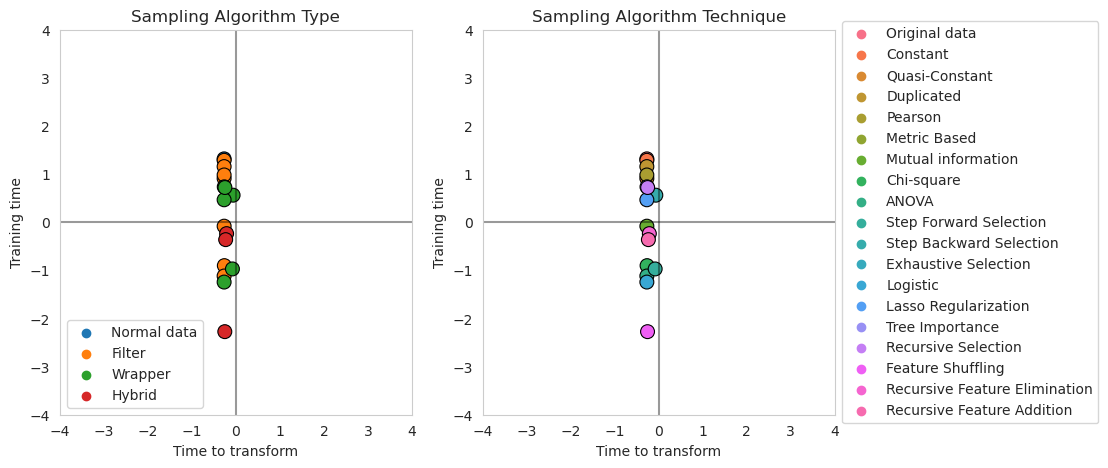

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))

sns.scatterplot(data = temp, x = "Time to transform",
                y = "Training time", hue = "Type", s = 100, ax = ax1, edgecolor = 'k')
ax1.grid(False)
ax1.set_ylim(-4, 4)
ax1.set_xlim(-4, 4)
ax1.legend(loc = "lower left")
ax1.axhline(0, color = 'k', alpha = 0.4)
ax1.axvline(0, color = 'k', alpha = 0.4)
ax1.set_title("Sampling Algorithm Type")

sns.scatterplot(data = temp, x = "Time to transform",
                y = "Training time", hue = "Technique", s = 100, ax = ax2, edgecolor = 'k')
ax2.grid(False)
ax2.set_ylim(-4, 4)
ax2.set_xlim(-4, 4)
ax2.legend(loc = 'center left',  bbox_to_anchor = (1, 0.5))
ax2.axhline(0, color = "k", alpha = 0.4)
ax2.axvline(0, color = "k", alpha = 0.4)
ax2.set_title("Sampling Algorithm Technique");

In [72]:
SUMMARY.groupby(["Type", "Technique"])[["Time to transform", "Training time"]].mean().style.highlight_max(axis=0, color = "red")

## Technique and model performance
In the course of evaluating the effectiveness of various techniques employed within this notebook, I have compiled a set of metrics that remain unbiased by features selection.
The metrics we are gonna be reviewing are the following:

**AUC Score (Area Under the ROC Curve):** The AUC (Area Under the Receiver Operating Characteristic Curve) score is a widely used metric for evaluating the performance of binary classification models. The ROC curve is created by plotting the True Positive Rate (Recall) against the False Positive Rate at various classification thresholds. The AUC score quantifies the area under this curve, ranging from 0 to 1. A higher AUC score indicates better discriminative ability of the model in distinguishing between the two classes. An AUC score of 0.5 suggests random guessing, while a score closer to 1 signifies excellent model performance.

**Accuracy:** Accuracy is a basic metric that measures the ratio of correctly predicted instances to the total number of instances in a dataset. It provides a general overview of the model's overall correctness. However, accuracy might not be suitable for imbalanced datasets where one class significantly outweighs the other. In such cases, high accuracy can be achieved by merely predicting the majority class, even if the minority class predictions are poor.

**Precision:** Precision, also known as Positive Predictive Value, gauges the proportion of true positive predictions out of all positive predictions made by the model. It's a measure of how well the model avoids falsely labeling instances as positive. A high precision indicates that when the model predicts a positive outcome, it is likely to be correct.

**Recall (Sensitivity):** Recall, also called Sensitivity or True Positive Rate, calculates the proportion of true positive predictions out of all actual positive instances in the dataset. It measures the model's ability to correctly identify positive cases. High recall implies that the model effectively captures most of the true positives, although it might also generate false positives.

**F1 Score:** The F1 Score is the harmonic mean of precision and recall. It offers a balanced perspective on a model's performance, especially when the class distribution is imbalanced. It takes both false positives and false negatives into account and is thus a useful metric when aiming for a balance between precision and recall.

These metrics collectively provide insights into different aspects of model performance, allowing practitioners to make informed decisions based on the specific goals and challenges of their classification tasks.

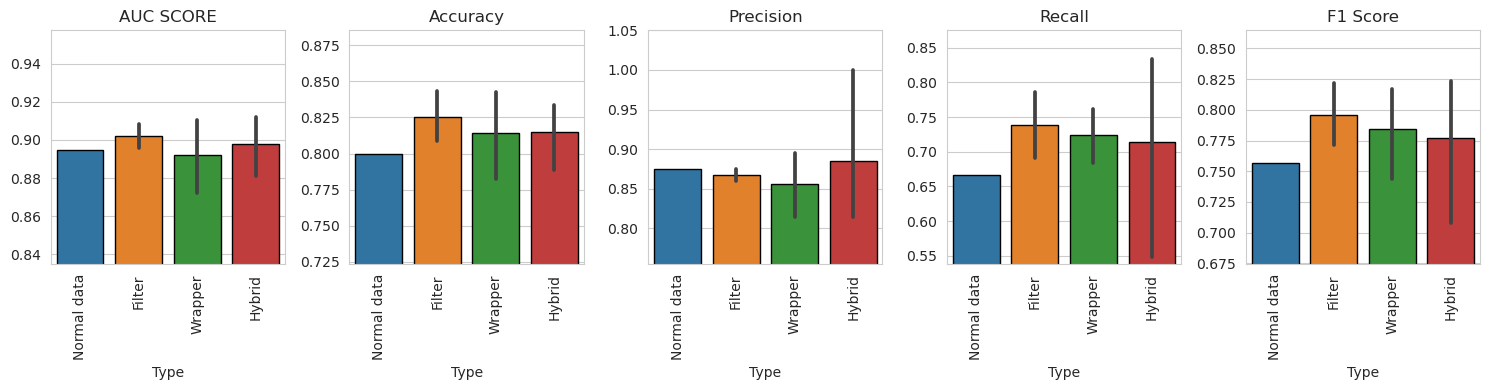

In [73]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4), sharey = False)

axes = [ax1, ax2, ax3, ax4, ax5]

for ax, feature in enumerate(["AUC SCORE", "Accuracy", "Precision", "Recall", "F1 Score"]):
    
    sns.barplot(data = SUMMARY, x = "Type", y = feature, ax = axes[ax], edgecolor = "k")
    axes[ax].set_xticklabels(SUMMARY["Type"].unique(), rotation = 90)
    axes[ax].set_ylim(bottom = SUMMARY[feature].min() - 0.01)
    axes[ax].set_title(f"{feature}")
    axes[ax].set_ylabel("")
plt.tight_layout()

### Overall score

In [74]:
from sklearn.preprocessing import MinMaxScaler 

temp = SUMMARY[['Technique', 'Type', 'AUC SCORE', 'Accuracy', 'Precision', 'Recall', "F1 Score"]]

scaler = MinMaxScaler()
temp[['AUC SCORE', 'Accuracy', 'Precision', 'Recall', "F1 Score"]] = scaler.fit_transform(temp[['AUC SCORE', 'Accuracy', 'Precision', 'Recall', "F1 Score"]])

In [75]:
temp["Overall score"] = temp[['AUC SCORE', 'Accuracy', 'Precision', 'Recall', "F1 Score"]].sum(axis = 1)


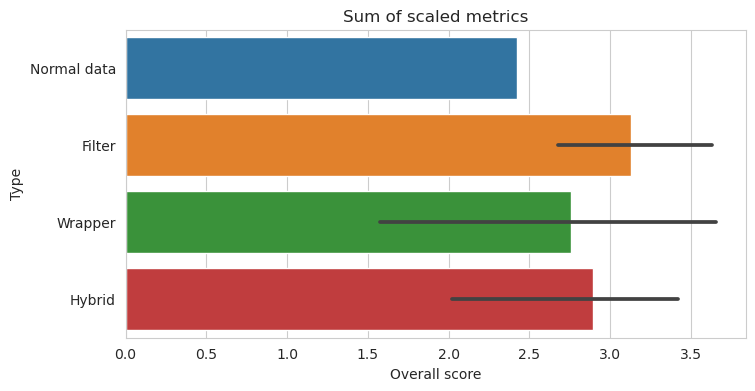

In [76]:
plt.figure(figsize = (8, 4))
sns.barplot(data = temp, y = "Type", x = "Overall score")
plt.title("Sum of scaled metrics");

In [77]:
temp.groupby("Type").mean().sort_values(by = "Overall score", ascending = False).style.highlight_max(axis = 0, color = "lightgreen")

,AUC SCORE,Accuracy,Precision,Recall,F1 Score,Overall score
Type,,,,,,
Filter,0.743952,0.687500,0.438764,0.615385,0.645047,3.130647
Hybrid,0.691398,0.611111,0.512750,0.538462,0.536993,2.890713
Wrapper,0.613825,0.607143,0.387727,0.571429,0.577561,2.757684
Normal data,0.651613,0.500000,0.468750,0.384615,0.419506,2.424485


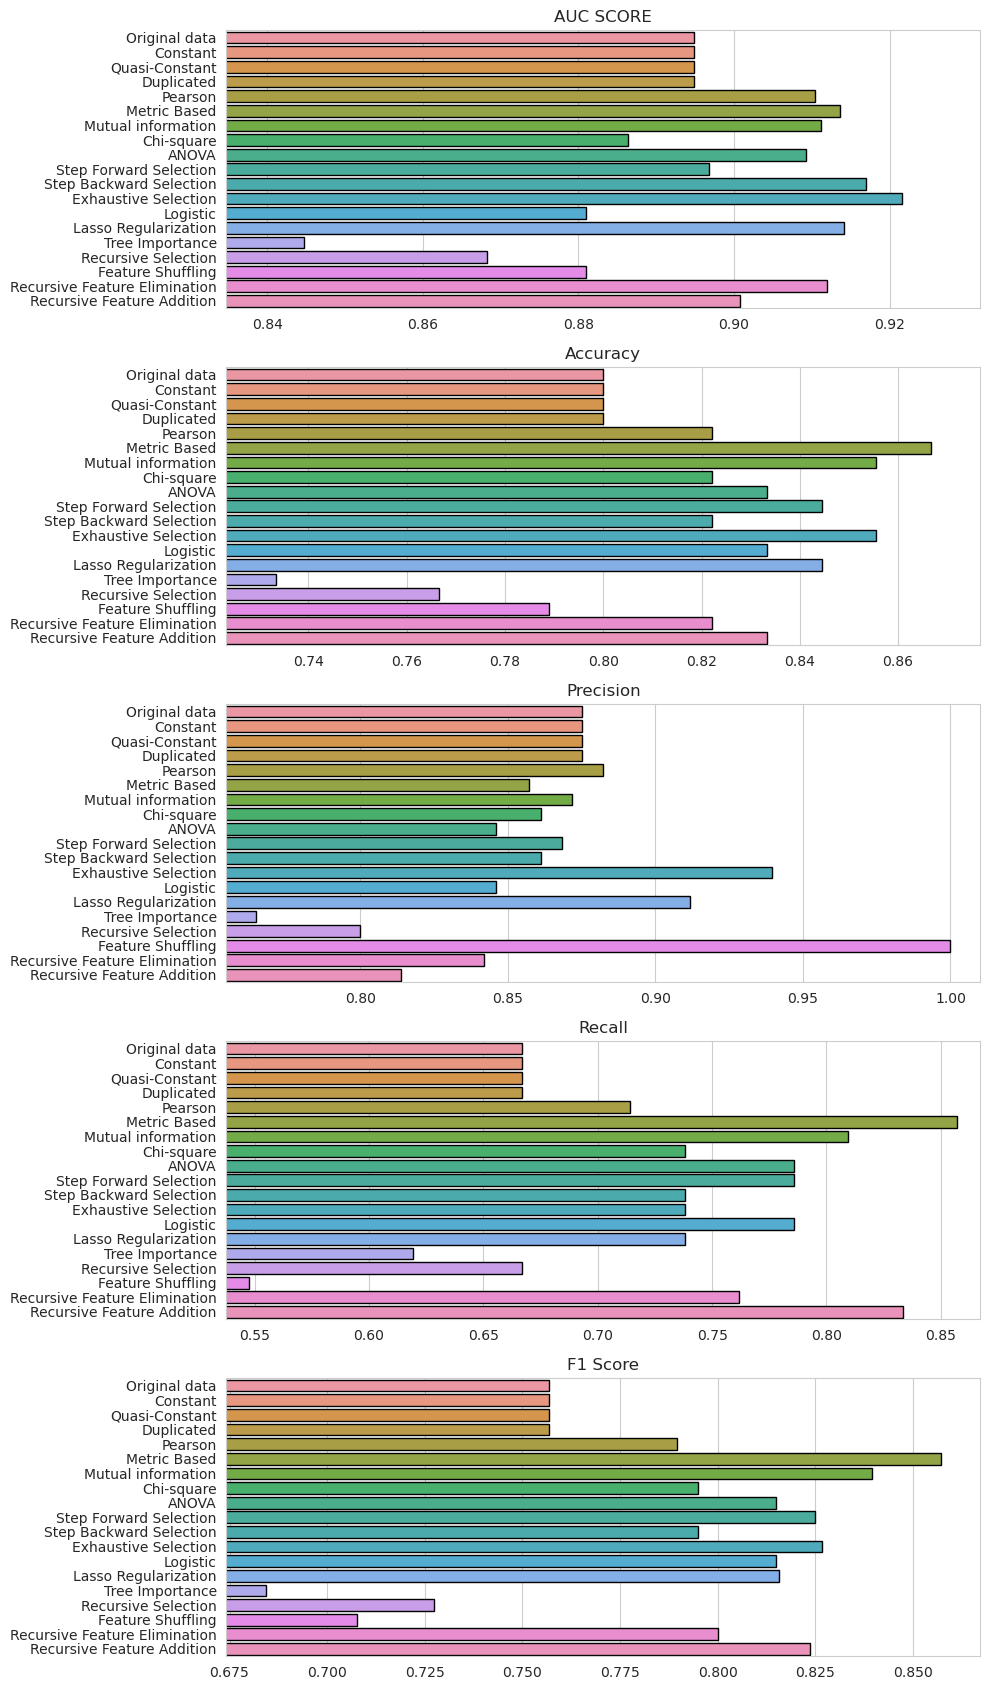

In [78]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 1, nrows = 5, figsize = (10, 17), sharey = False)

axes = [ax1, ax2, ax3, ax4, ax5]

for ax, feature in enumerate(["AUC SCORE", "Accuracy", "Precision", "Recall", "F1 Score"]):
    
    sns.barplot(data = SUMMARY, y = "Technique", x = feature, ax = axes[ax], edgecolor = "k")
    axes[ax].set_xlim(left = SUMMARY[feature].min() - 0.01, right = SUMMARY[feature].max() + 0.01)
    axes[ax].set_title(f"{feature}")
    axes[ax].set_xlabel("")
    axes[ax].set_ylabel("")
    
plt.tight_layout()

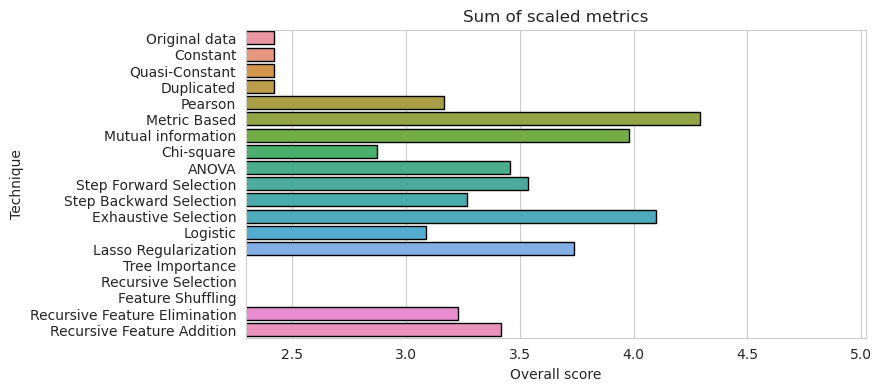

In [79]:
plt.figure(figsize = (8, 4))
sns.barplot(data = temp, y = "Technique", x = "Overall score", edgecolor = 'k')
plt.xlim(left = 2.3, right = 5.02)
plt.title("Sum of scaled metrics");

In [80]:
temp.groupby("Technique").mean().sort_values(by = "Overall score", ascending = False).style.highlight_max(axis = 0, color = "lightgreen")

,AUC SCORE,Accuracy,Precision,Recall,F1 Score,Overall score
Technique,,,,,,
Metric Based,0.896774,1.000000,0.392857,1.000000,1.000000,4.289631
Exhaustive Selection,1.000000,0.916667,0.742424,0.615385,0.823768,4.098244
Mutual information,0.864516,0.916667,0.455128,0.846154,0.898014,3.980479
Lasso Regularization,0.903226,0.833333,0.625000,0.615385,0.760870,3.737813
Step Forward Selection,0.677419,0.833333,0.440789,0.769231,0.814130,3.534903
ANOVA,0.838710,0.750000,0.346154,0.769231,0.755233,3.459328
Recursive Feature Addition,0.729032,0.750000,0.209302,0.923077,0.805627,3.417038
Step Backward Selection,0.938710,0.666667,0.409722,0.615385,0.639911,3.270394
Recursive Feature Elimination,0.874194,0.666667,0.328947,0.692308,0.669565,3.231680


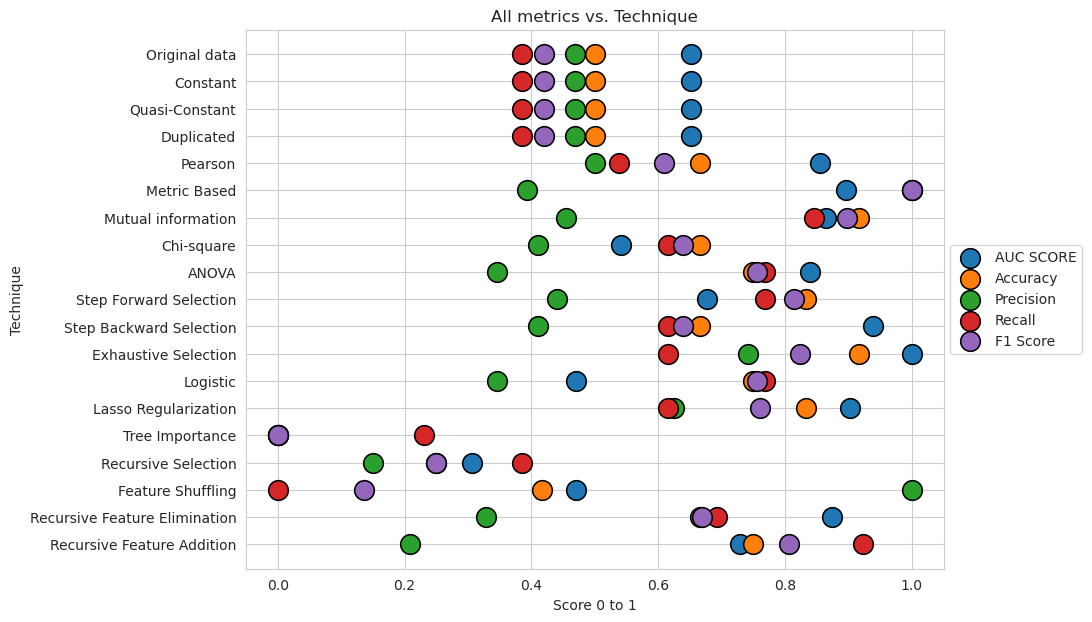

In [81]:
plt.figure(figsize = (9, 7))
sns.scatterplot(data = temp, x = "AUC SCORE"
                , y = "Technique", s = 200, edgecolor = 'k', label = "AUC SCORE", )

sns.scatterplot(data = temp, x = "Accuracy"
                , y = "Technique", s = 200, edgecolor = 'k', label = "Accuracy")

sns.scatterplot(data = temp, x = "Precision"
                , y = "Technique", s = 200, edgecolor = 'k', label = "Precision")

sns.scatterplot(data = temp, x = "Recall"
                , y = "Technique", s = 200, edgecolor = 'k', label = "Recall")

sns.scatterplot(data = temp, x = "F1 Score"
                , y = "Technique", s = 200, edgecolor = 'k', label = "F1 Score")

plt.legend(loc = 'center left',  bbox_to_anchor = (1, 0.5))
plt.xlabel("Score 0 to 1")
plt.title("All metrics vs. Technique");

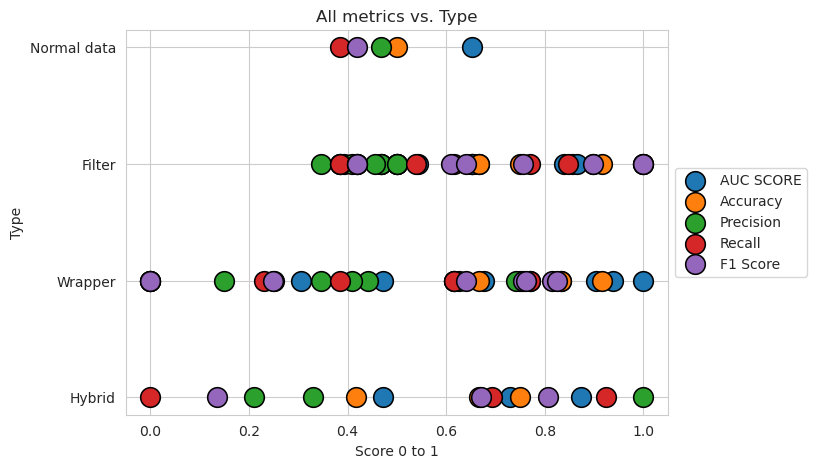

In [82]:
plt.figure(figsize = (7, 5))

sns.scatterplot(data = temp, x = "AUC SCORE"
                , y = "Type", s = 200, edgecolor = 'k', label = "AUC SCORE")

sns.scatterplot(data = temp, x = "Accuracy"
                , y = "Type", s = 200, edgecolor = 'k', label = "Accuracy")

sns.scatterplot(data = temp, x = "Precision"
                , y = "Type", s = 200, edgecolor = 'k', label = "Precision")

sns.scatterplot(data = temp, x = "Recall"
                , y = "Type", s = 200, edgecolor = 'k', label = "Recall")

sns.scatterplot(data = temp, x = "F1 Score"
                , y = "Type", s = 200, edgecolor = 'k', label = "F1 Score")

plt.xlabel("Score 0 to 1")
plt.legend(loc = 'center left',  bbox_to_anchor = (1, 0.5))
plt.title("All metrics vs. Type");

## Top Features dropped and kept

In [83]:
DROPPED = list()
KEPT = list()

for list_droped in SUMMARY['Features dropped'].to_list():
    DROPPED.extend(list_droped)
    
for list_kept in SUMMARY['Features kept'].to_list():
    KEPT.extend(list_kept)

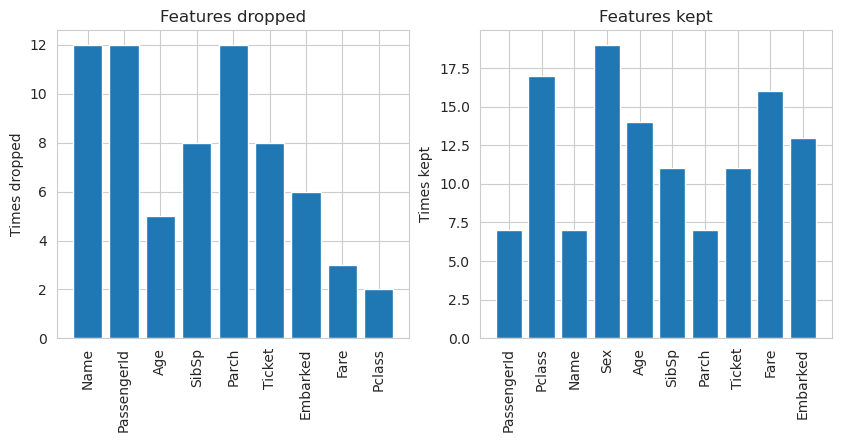

In [84]:
from collections import Counter

dropped_names, dropped_values = list(Counter(DROPPED).keys()), list(Counter(DROPPED).values())

kept_names, kept_values = list(Counter(KEPT).keys()), list(Counter(KEPT).values())

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4))

ax1.bar(range(len(Counter(DROPPED))), dropped_values, tick_label = dropped_names)
ax1.set_xticklabels(dropped_names, rotation = 90)
ax1.set_title("Features dropped")
ax1.set_ylabel("Times dropped")
ax2.bar(range(len(Counter(KEPT))), kept_values, tick_label = kept_names)
ax2.set_xticklabels(kept_names, rotation = 90)
ax2.set_title("Features kept")
ax2.set_ylabel("Times kept");

In [85]:
FEATURES = pd.DataFrame([dict(Counter(DROPPED)), dict(Counter(KEPT))],
             index = ["Dropped", "Kept"]).fillna(0).T
FEATURES

,Dropped,Kept
Name,12.0,7.0
PassengerId,12.0,7.0
Age,5.0,14.0
SibSp,8.0,11.0
Parch,12.0,7.0
Ticket,8.0,11.0
Embarked,6.0,13.0
Fare,3.0,16.0
Pclass,2.0,17.0
Sex,0.0,19.0


In [86]:
# Most dropped or worst featurees
FEATURES["Dropped"].sort_values(ascending = False).to_frame().head(3)

,Dropped
Name,12.0
PassengerId,12.0
Parch,12.0


In [87]:
# Most kept or best featurees
FEATURES["Kept"].sort_values(ascending = False).to_frame().head(3)

,Kept
Sex,19.0
Pclass,17.0
Fare,16.0


## Average dropping by technique and type

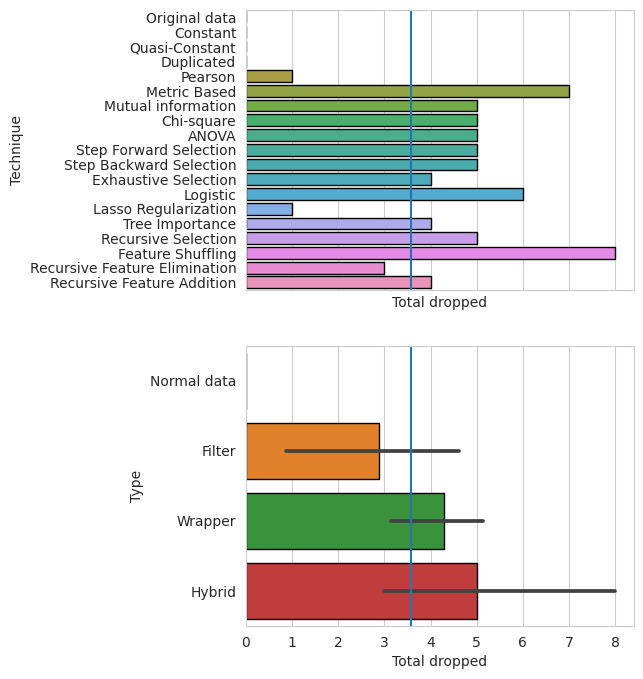

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (5, 8), sharex = True)

sns.barplot(data = SUMMARY, y = "Technique", x = "Total dropped", ax = ax1, edgecolor = 'k')
ax1.axvline(SUMMARY["Total dropped"].mean())


sns.barplot(data = SUMMARY, y = "Type", x = "Total dropped", ax = ax2, edgecolor = 'k')
ax2.axvline(SUMMARY["Total dropped"].mean());

# Final Thoughts

While feature selection undeniably plays a pivotal role in enhancing the performance and interpretability of machine learning models, it's essential to recognize that it's just one piece of the broader puzzle. The journey toward building robust and impactful machine learning solutions involves a multifaceted approach that extends beyond feature selection.

**Model Architecture and Complexity:** Choosing an appropriate model architecture tailored to the problem at hand is equally vital. The model's complexity should be aligned with the complexity of the data and the underlying relationships. Striking the right balance can prevent overfitting or underfitting, which can greatly affect a model's generalization capabilities.

**Data Preprocessing:** Feature engineering, data cleaning, normalization, and handling missing values all contribute to the overall data preprocessing pipeline. Neglecting these steps can lead to suboptimal model performance and erroneous insights. A meticulous data preprocessing process enhances the quality of the features available for selection.

**Hyperparameter Tuning:** The model's hyperparameters profoundly impact its performance. Properly tuning hyperparameters can transform a mediocre model into a highly accurate one. Ignoring this step risks leaving performance gains on the table.

**Domain Knowledge:** Incorporating domain expertise can significantly enrich the feature selection process. A thorough understanding of the problem domain can guide the selection of features that are not only relevant but also align with the underlying mechanics of the problem.

**Validation and Testing:** Robust validation and testing procedures are critical to ensure that the selected features and the trained model generalize well to unseen data. This guards against over-optimization and helps evaluate a model's real-world performance.

**Interpretability:** While optimizing model performance is paramount, interpretability should not be overlooked. Understanding the relationships between features and predictions is crucial for building trust in the model's decisions.

In conclusion, feature selection is undoubtedly a cornerstone of effective machine learning, but it exists within a broader ecosystem of considerations. Embracing a holistic approach that encompasses model architecture, data preprocessing, hyperparameter tuning, domain knowledge, validation, testing, and interpretability ensures that the end result is not only accurate but also reliable, insightful, and capable of driving informed decisions.


# References

- [Feature-Engine](https://feature-engine.trainindata.com/en/latest/)
- [MLxtend](https://rasbt.github.io/mlxtend/)
- [Scikit-learn](https://scikit-learn.org/stable/)
- [Feature Selection for Machine Learning](https://www.trainindata.com/p/feature-selection-for-machine-learning)